### Author: Vaishnav Krishna P
- vyshnavkrishnap2020@gmail.com

### 1. Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. **Import** Libraries

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix, matthews_corrcoef
import seaborn as sns

### 3. Define Dataset Path

In [12]:
data_dir = "/content/drive/MyDrive/TransformedImages_NoSkeleton"

IMG_SIZE = 224   # Required for ResNet
BATCH_SIZE = 16


### 4. Load Dataset

In [13]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

Found 547 files belonging to 2 classes.
Using 438 files for training.
Found 547 files belonging to 2 classes.
Using 109 files for validation.


### 5. Apply Preprocessing

In [14]:
train_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), y))
val_dataset = val_dataset.map(lambda x, y: (preprocess_input(x), y))

### 6. Load ResNet50 Base Model

In [15]:
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False   # Freeze base model

### 7. Build Final Model

In [16]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])


### 8. Compile Model

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

### 9. Add Early Stopping

In [18]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

### 10. Train Model

In [19]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stop]
)


Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step - accuracy: 0.5309 - loss: 0.7955 - val_accuracy: 0.7156 - val_loss: 0.5895
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.6059 - loss: 0.6635 - val_accuracy: 0.7339 - val_loss: 0.5648
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.6684 - loss: 0.6109 - val_accuracy: 0.7339 - val_loss: 0.5550
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.7017 - loss: 0.5961 - val_accuracy: 0.7156 - val_loss: 0.5494
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - accuracy: 0.7137 - loss: 0.5762 - val_accuracy: 0.7248 - val_loss: 0.5546
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.6772 - loss: 0.5749 - val_accuracy: 0.7339 - val_loss: 0.5515
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.7214 - loss: 0.5379 - val_accuracy: 0.7064 - val_loss: 0.5583


### 11. Get Predictions on Validation Set

In [20]:
y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images)
    preds = (preds > 0.5).astype(int)

    y_true.extend(labels.numpy())
    y_pred.extend(preds.flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


### 12. Compute Metrics

In [21]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)   # Sensitivity
f1 = f1_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall (Sensitivity):", recall)
print("F1 Score:", f1)
print("MCC:", mcc)


Accuracy: 0.7155963302752294
Precision: 0.7307692307692307
Recall (Sensitivity): 0.4418604651162791
F1 Score: 0.5507246376811594
MCC: 0.38508888619225756


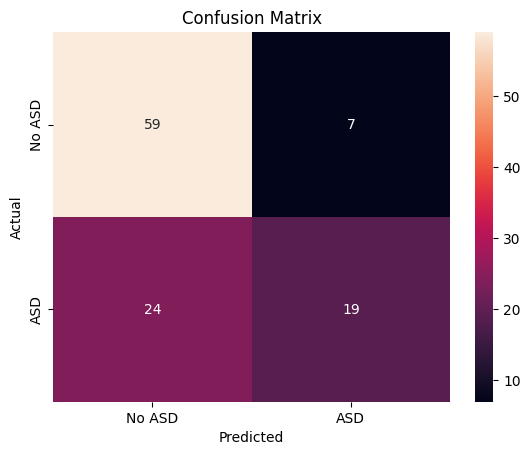

In [22]:
cm = confusion_matrix(y_true, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=["No ASD", "ASD"],
            yticklabels=["No ASD", "ASD"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

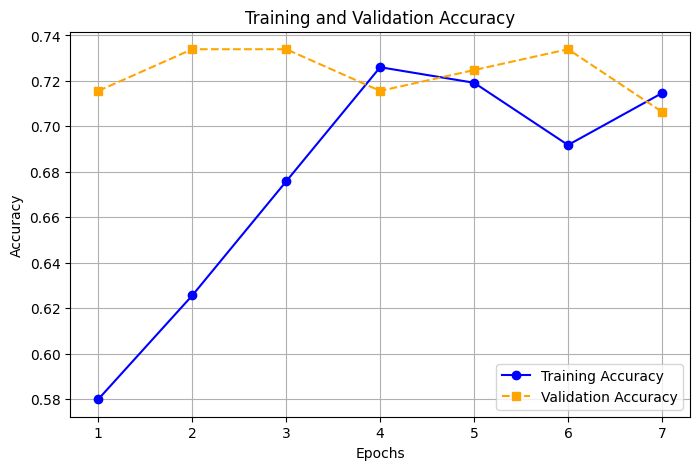

In [23]:
# Get metrics from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Accuracy plot
plt.figure(figsize=(8,5))
plt.plot(epochs_range, acc, marker='o', linestyle='-', color='blue')
plt.plot(epochs_range, val_acc, marker='s', linestyle='--', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.xticks(epochs_range)
plt.grid(True)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

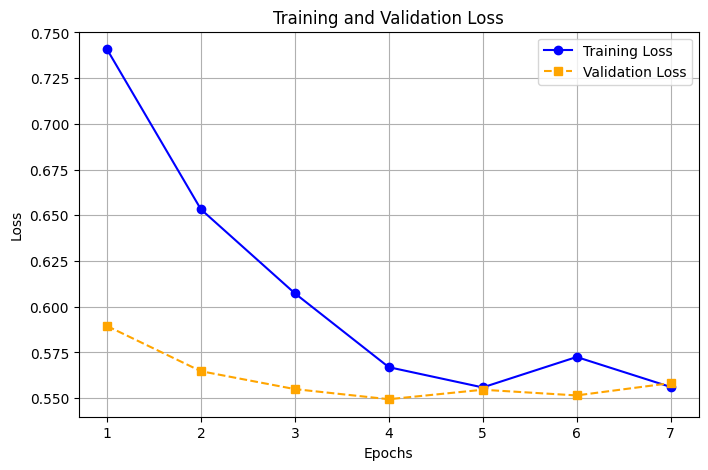

In [24]:
# Loss plot
plt.figure(figsize=(8,5))
plt.plot(epochs_range, loss, marker='o', linestyle='-', color='blue')
plt.plot(epochs_range, val_loss, marker='s', linestyle='--', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xticks(epochs_range)
plt.grid(True)
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()
